In [1]:
import numpy as np
import torch_geometric
from mlcolvar.data import graph as gdata

In [2]:
from mlcolvar.data.graph.datamodule import GraphDataModule
from mlcolvar.utils.io import create_dataset_from_trajectories

dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb'],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)

datamodule_graph = GraphDataModule(dataset_graph, shuffle=[1, 0])
print(datamodule_graph)


from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

dataset_ff = create_dataset_from_files(file_names=['data/colvar_r.dat',
                                                   'data/colvar_p.dat'],
                                                   filter_args={'regex': 'd'})

datamodule_ff = DictModule(dataset_ff, lengths=[1])


DictModule(dataset -> DictDataset( "data_list": 1600, "z_table": 2, "cutoff": 8.0 ),
		     train_loader -> DictLoader(length=0.8, batch_size=1600, shuffle=1),
		     valid_loader -> DictLoader(length=0.2, batch_size=1600, shuffle=0))
Class 0 dataframe shape:  (800, 24)
Class 1 dataframe shape:  (800, 24)

 - Loaded dataframe (1600, 24): ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'walker', 'labels']
 - Descriptors (1600, 21): ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']


In [3]:
dataset_graph

DictDataset( "data_list": 1600, "z_table": 2, "cutoff": 8.0 )

In [4]:
# a = dataset_graph['z_table']
# new = []
# for i in a:
#     new.append(int(i))
# new

# dataset_graph['z_table'] = new


In [5]:
import torch
d = {'a' : torch.zeros(10), 'b': 0.1}

torch.tile(torch.Tensor([d['b']]), (len(d["a"]), 1))

tensor([[0.1000],
        [0.1000],
        [0.1000],
        [0.1000],
        [0.1000],
        [0.1000],
        [0.1000],
        [0.1000],
        [0.1000],
        [0.1000]])

In [4]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph['cutoff'],
                        atomic_numbers=dataset_graph['z_table'],
                        n_bases=6,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32
                    )

# gnn_model = SchNetModel(n_out=1,
#                         cutoff=dataset_graph.cutoff,
#                         atomic_numbers=dataset_graph.atomic_numbers,
#                         n_bases=6,
#                         n_layers=2,
#                         n_filters=32,
#                         n_hidden_channels=32
#                     )

In [5]:
from mlcolvar.cvs.supervised.deeptda_merged import DeepTDA

model_graph = DeepTDA(n_states=2,
                        n_cvs=1,
                        target_centers=[-7, 7],
                        target_sigmas=[0.2, 0.2],
                        layers=[21, 15, 10, 1],
                        gnn_model=gnn_model)

model_ff = DeepTDA(n_states=2,
                    n_cvs=1,
                    target_centers=[-7, 7],
                    target_sigmas=[0.2, 0.2],
                    layers=[21, 15, 10, 1],
                    gnn_model=None)



/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/cvs/supervised/deeptda_merged.py:137: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.gnn_model._model_type is 'gnn':
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'gnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['gnn_model'])`.


In [6]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='gpu',
    max_epochs=5,
    enable_model_summary=False, 
    limit_val_batches=0
)

trainer.fit(model_graph, datamodule_graph)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=5` reached.


In [18]:
datamodule_ff.setup()

a = datamodule_ff.train_dataloader()
a.dataset['data']

datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)


[{'data_list': DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281]),
  'z_table': [tensor([6, 6, 6,  ..., 6, 6, 6]),
   tensor([9, 9, 9,  ..., 9, 9, 9])],
  'cutoff': tensor([8., 8., 8.,  ..., 8., 8., 8.])}]

In [10]:
trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='gpu',
    max_epochs=5,
    enable_model_summary=False, 
    limit_val_batches=0
)

trainer.fit(model_ff, datamodule_ff)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [12]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model_graph(test)

out_ff = model_ff(dataset_ff['data'])

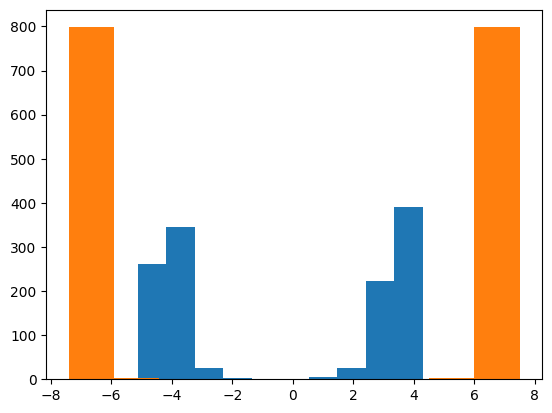

In [13]:
import matplotlib.pyplot as plt

plt.hist(out_graph.detach().squeeze())
plt.hist(out_ff.detach().squeeze())
plt.show()

In [ ]:
DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])
DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])
DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])
DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])

In [ ]:
{'edge_index': tensor([[   0,    0,    0,  ..., 8959, 8959, 8959],
        [   1,    4,    5,  ..., 8955, 8956, 8957]], device='cuda:0'), 'shifts': tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0'), 'unit_shifts': tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0'), 'positions': tensor([[-2.6081, -2.1008,  0.3736],
        [-2.4060, -1.0921, -0.7459],
        [-2.4521, -3.5211,  0.1885],
        ...,
        [-2.1364, -3.1386,  0.5862],
        [-3.5091, -0.7473, -2.1322],
        [-1.6128, -0.9524, -0.9889]], device='cuda:0'), 'cell': tensor([[100.,   0.,   0.],
        [  0., 100.,   0.],
        [  0.,   0., 100.],
        ...,
        [100.,   0.,   0.],
        [  0., 100.,   0.],
        [  0.,   0., 100.]], device='cuda:0'), 'node_attrs': tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]], device='cuda:0'), 'graph_labels': tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]], device='cuda:0'), 'n_system': tensor([[7.],
        [7.],
        [7.],
        ...,
        [7.],
        [7.],
        [7.]], device='cuda:0'), 'weight': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'), 'batch': tensor([   0,    0,    0,  ..., 1279, 1279, 1279], device='cuda:0'), 'ptr': tensor([   0,    7,   14,  ..., 8946, 8953, 8960], device='cuda:0')}